In [1]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.vector_ar.vecm import coint_johansen

from scipy.stats import linregress

In [2]:
#We wish to analyze the cointegration of the firms that make up FAANG
tickers = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG' ]

df= yf.download(tickers)

type(df)

[*********************100%%**********************]  5 of 5 completed


pandas.core.frame.DataFrame

In [3]:
#subset the data for the adjusted close and remove bad data
df = df['Adj Close'].dropna()

In [4]:
df.tail()

Ticker,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2024-09-19,228.869995,189.869995,163.240005,559.099976,704.320007
2024-09-20,228.199997,191.600006,164.639999,561.349976,701.030029
2024-09-23,226.470001,193.880005,163.070007,564.409973,705.369995
2024-09-24,227.369995,193.960007,163.639999,563.330017,722.260010
2024-09-25,226.369995,192.529999,162.990005,568.309998,721.559998


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

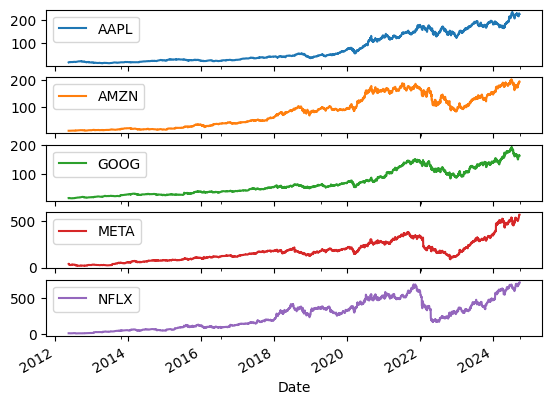

In [5]:
#here the plots suggest there is some level of cointegration for all 5 firms. They tend to rise and fall at the same times for reasons that are obviounp.float64(-2.86787s but not explicitly defined.
df.plot(subplots=True)

# GRANGER CAUSALITY TEST

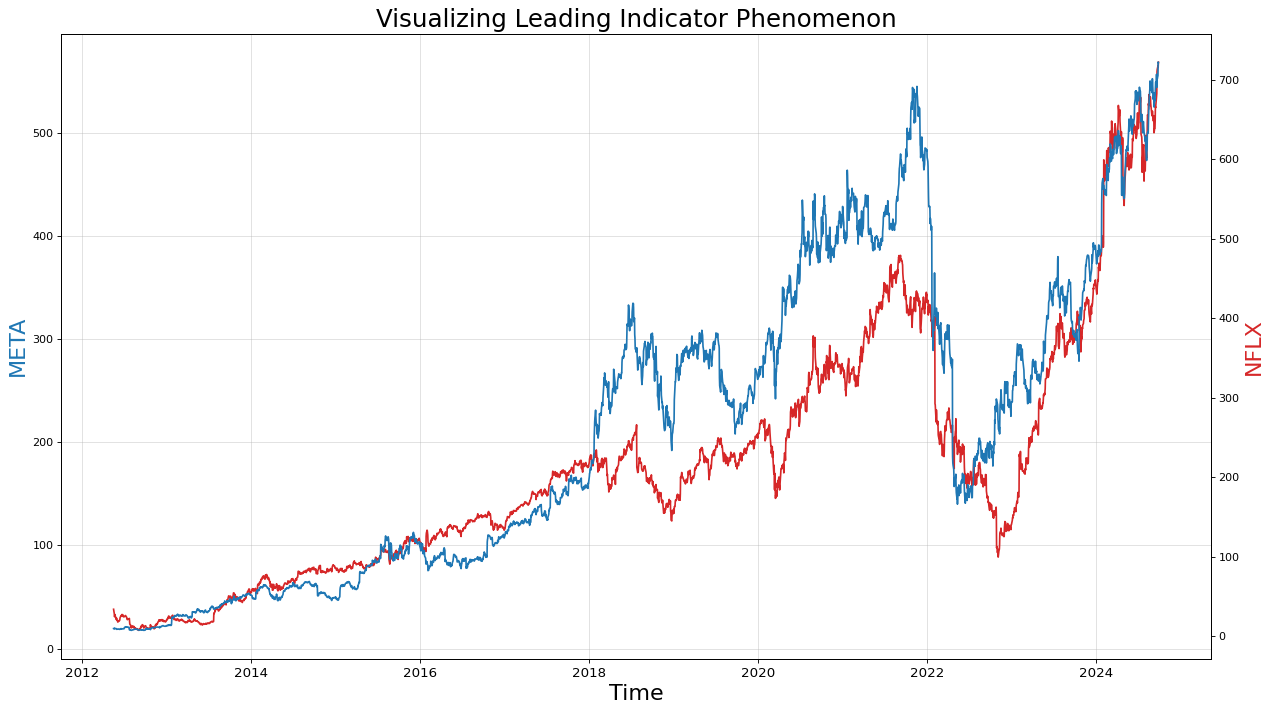

In [6]:
#In a Granger Causality test we aim to classify a variable as leading another. implying it has a signifcant impact on another variables future.
    #Here we visualize the lead effect in the time series data
x = df.index
y1 = df['META']
y2 = df['NFLX']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi=80)
ax1.plot(x,y1, color='tab:red')


# plot line2 (right y axis)
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('META', color='tab:blue', fontsize=20)
ax1.grid(alpha=.4)

ax2.set_ylabel("NFLX", color='tab:red', fontsize=20)
ax2.set_title("Visualizing Leading Indicator Phenomenon", fontsize=22)
fig.tight_layout()
plt.show()


In [7]:
# the above graphic clearly indicates a relationship between META and NFLX 
#   specifically we can look at the time period from 2018 to 2022 where the adjusted close were the same, an event that does not accure regularly as shown in our data
# the spread between META and NFLX fluctuates alot in this time period in favor of NFLX. we could enter positions at times where the spread is less in favour of NFLX(as for this period it is always it its favour)
#   and exit them when the spread reaches a desired threshold


In [8]:
#Granger Causality Test
    #We will test META anf NFLX with a null hypthosis that NFLX does NOT Granger cause META. Our desired p-value is 0.05

import statsmodels.api as sm 
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
variables = ['META', 'NFLX']
data = df[variables]

maxlag0 = 7
test = 'ssr_chi2test'

In [9]:
def grangers_causation_matrix(data, variables, test ='ssr_chi2test',verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag0, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag0)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [10]:
#interpreting the table is simple, we simply recall our signifcance level of 0.05 and reject the null hypthosis that X does NOT granger cause Y
#   here if we take NFLX as X and META as Y, we are looking for a p value of less than 0.05 and reject that NFLX does NOT granger cause META
grangers_causation_matrix(data, variables= data.columns)


,META_x,NFLX_x
META_y,1.0000,0.003
NFLX_y,0.0291,1.000


In [11]:
# In practice we would look for cointegrated assets and then apply the granger causality text to understand the relationship in which these securities are cointegrated. 
# Our granger casuality test results in a P value of 0.0013 < 0.05 thus we can claim NFLX is a good predictor for META

# COINTEGRATION TEST

In [12]:
# lets look at NFLX and META

stocks = ['META', 'NFLX']
start_date = '2022-10-01'
end_date = '2024-08-01'

data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']


[*********************100%%**********************]  2 of 2 completed


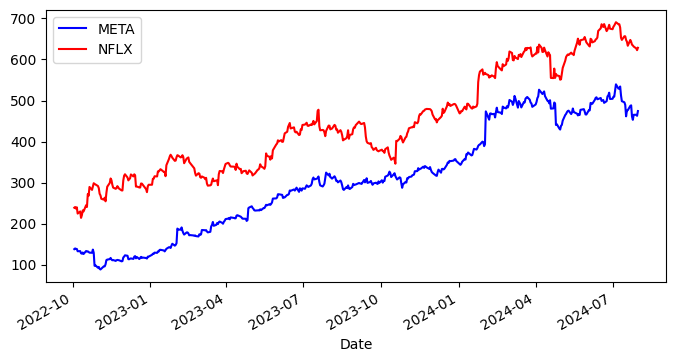

In [13]:
data.META.plot(figsize=(8,4), label= 'META', color='blue')
data.NFLX.plot(figsize=(8,4), label='NFLX', color='red')
plt.legend()
plt.show()



In [14]:
data['spread'] = data['NFLX'] - data['META']


Text(0.5, 1.0, 'Spread between ')

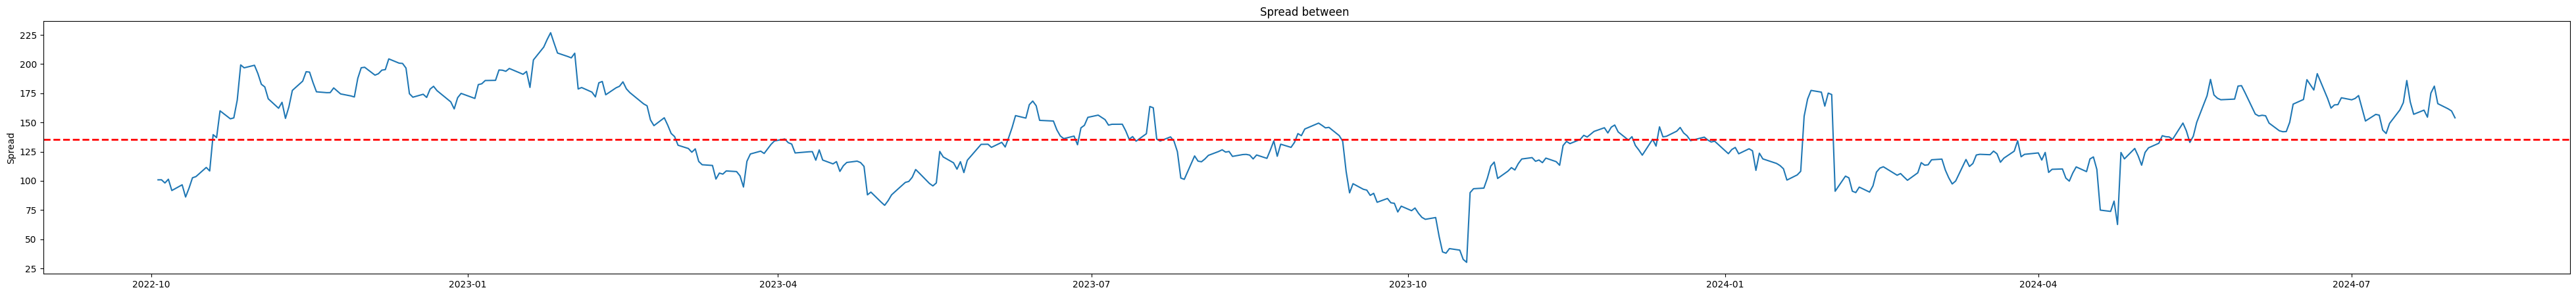

In [15]:

plt.plot(data.index, data.spread)

avg_delta = data.spread.mean()

plt.axhline(y=avg_delta, color='red', linestyle='--', linewidth=2)



plt.subplots_adjust(left=4, right=10, top=0.9, bottom=0.1)

plt.ylabel('Spread')
plt.title("Spread between ")


In [16]:
#Engle Granger Test with confidence level 95% (alpha=0.05)
# note this test still results in the conclusion that the time series data is 
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller

result = linregress(data.META, data.NFLX)

predict = result.slope * data.NFLX + result.intercept

residuals = data.META - predict

adf = adfuller(residuals)

print(f"---regression result---\n\nr-value: {result.rvalue}\np-value: {result.pvalue}\n\n ---Augmented Dickey Fuller test result---\n\n test stat: {adf[0]}\n critical value: {adf[4]['5%']}")

adf[1]

---regression result---

r-value: 0.9647767784670325
p-value: 3.6287803005115096e-267

 ---Augmented Dickey Fuller test result---

 test stat: -2.975937121558052
 critical value: -2.867871300049488


0.03720349786875305

with a 95% confidence interval we reject the null hypothesis that META and NFLX are NOT cointegrated

In [17]:
from statsmodels.tsa.stattools import adfuller
# computing ADF test statistics( we are checking if the detla time series is a stationary time series)
'''
fi the delta between two stock prices is stationary, it means that the difference between the prices of the two stocks remains relatively constant over time. 
This implies that while the individual stock prices may fluctuate, the spread between them does not exhibit a long-term trend, and its mean, variance, and autocorrelation structure remain stable.

In practical terms, a stationary delta between two stock prices suggests that:

    Mean Reversion: The difference between the two stock prices tends to revert to a stable mean. If the spread deviates from this mean, it is likely to move back toward it over time.

    Constant Variability: The variability in the delta remains consistent over time, indicating no increasing or decreasing trend in the spread's volatility.
'''
adf = adfuller(data.Delta, maxlag=7)

print(adf[0], adf[4])

AttributeError: 'DataFrame' object has no attribute 'Delta'

with a 95% confidence interval we reject the null hyptohesis that the spread between NFLX and META is NOT cointegrated